In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from pipeline import *
from data_utils import *
from utils import *
import vis
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from tflearn.data_utils import to_categorical, pad_sequences
from sklearn.metrics import accuracy_score
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import style

%matplotlib inline
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA

In [2]:
# Need to load checkpoint
checkpoint_id = "cnn_rnn_end_to_end_cifar100"
model = load_model(checkpoint_id, is_training=True, checkpoint_model_id=checkpoint_id)

Loading model...
../tensorboard_logs/cnn_rnn_end_to_end_cifar100/
../checkpoints/cnn_rnn_end_to_end_cifar100/
../best_checkpoints/cnn_rnn_end_to_end_cifar100/
Checkpoint loaded.
Model loaded.


In [72]:
# Load dataset
X_test, y_test, fine_or_coarse_test = load_pyramid_test_subset(test_subset="seen_fine")
fine_or_coarse_test = np.zeros_like(fine_or_coarse_test)

loading cifar batch training batch 1 of 1
loading cifar batch testing batch 1 of 1
(10000, 32, 32, 3)


In [56]:
X_test, y_test, fine_or_coarse_test = load_pyramid_test_subset(test_subset="seen_coarse")

loading cifar batch training batch 1 of 1
loading cifar batch testing batch 1 of 1
(10000, 32, 32, 3)


In [65]:
X_test, y_test, fine_or_coarse_test = load_pyramid_test_subset(test_subset="unseen")

loading cifar batch training batch 1 of 1
loading cifar batch testing batch 1 of 1
(10000, 32, 32, 3)


In [192]:
X_test, y_test, fine_or_coarse_test = load_data_pyramid(dataset='cifar100_joint', return_subset='gate_only')

def form_y_for_cnn_rnn(y, fine_or_coarse_gate, coarse_dim, fine_dim):
    coarse_indexes, fine_indexes = y[:, 1] + fine_dim, y[:, 0]
    total_dim = coarse_dim + fine_dim + 1

    locations_of_end_token = fine_or_coarse_gate * -2 + 1  # 1 for not end token, -1 for end token
    fine_indexes = fine_indexes * locations_of_end_token  # any end token now has negative index
    fine_indexes[fine_indexes < 0] = total_dim - 1  # swap negative for end token

    coarse_one_hots = to_categorical(coarse_indexes, total_dim)
    fine_one_hots = to_categorical(fine_indexes, total_dim)

    y_joint = np.concatenate((coarse_one_hots, fine_one_hots), axis=1)

    return y_joint

loading cifar batch training batch 1 of 1
loading cifar batch testing batch 1 of 1
mountain
forest
seal
mushroom
sea
tulip
camel
butterfly
cloud
apple
sea
skunk
streetcar
rocket
lamp
lion
tulip
wolf
rose
orange
rose
mountain
skunk
dinosaur
chimpanzee
can
keyboard
bicycle
bicycle
rose
chair
plate
lawn_mower
turtle
palm_tree
shark
pickup_truck
boy
couch
house
porcupine
cockroach
mountain
shark
palm_tree
clock
lawn_mower
pickup_truck
skunk
castle
beaver
bee
bottle
pear
baby
flatfish
sea
oak_tree
leopard
rocket
snail
crocodile
camel
rabbit
beetle
girl
lion
sunflower
porcupine
tulip
raccoon
train
ray
trout
flatfish
flatfish
sunflower
bowl
snail
clock
sea
snake
orchid
bee
dinosaur
tractor
snake
forest
boy
ray
clock
caterpillar
crocodile
chimpanzee
bus
chimpanzee
mouse
skunk
house
girl
crab
sweet_pepper
maple_tree
whale
lion
rocket
skyscraper
castle
pear
pine_tree
couch
chair
crocodile
apple
bottle
sea
bicycle
lion
pear
palm_tree
tank
bowl
cattle
tulip
forest
chair
chimpanzee
mouse
rose
man
b

In [210]:
X, Y, X_val, Y_val, X_test, Y_test = load_cifar(dataset='cifar10', normalize=False)

loading cifar batch training batch 1 of 5
loading cifar batch training batch 2 of 5
loading cifar batch training batch 3 of 5
loading cifar batch training batch 4 of 5
loading cifar batch training batch 5 of 5
loading cifar batch testing batch 1 of 1
120.707565124
63.3055834253


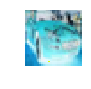

In [211]:
index = 5
image_to_show = X[index]
plt.figure(num=None, figsize=(1, 1), dpi=32, facecolor='w', edgecolor='k')
plt.axis('off')
plt.imshow(image_to_show, interpolation='nearest')
#print fine_label_names[y[index][0]]

In [164]:
# Let's visualize
from tflearn.data_utils import shuffle, to_categorical
y_test_joint = form_y_for_cnn_rnn(y_test, fine_or_coarse_test, 20, 100)
y_test_joint = np.reshape(y_test_joint, (-1, 2, 121))
y_test_joint = np.argmax(y_test_joint, 2)
y_test_joint = simplifyToHierarchicalFormat(y_test_joint)

print y_test_joint

[ 19  29   0 ...,   3   7 101]


In [189]:
# Print out examples
import pickle
p = pickle.load(open("coarse_to_fine_map.pickle"))
fine_grain_classes = p["fruit_and_vegetables"] + p["fish"]

relevantIndexes = [fine_label_names.index(fine_grain_class) for fine_grain_class in fine_grain_classes]

print relevantIndexes
print fine_grain_classes

X_test_fine_visualize = []
y_test_fine_visualize = []
for ii in range(len(X_test_fine)):
    if y_test_joint[ii] in relevantIndexes:
        X_test_fine_visualize.append(X_test[ii])
        y_test_fine_visualize.append(y_test_joint[ii])

        
y_test_fine_visualize = [relevantIndexes.index(ii) for ii in y_test_fine_visualize]
y_test_fine_visualize = to_categorical(y_test_fine_visualize, len(fine_grain_classes))

[0, 51, 53, 57, 83, 1, 32, 67, 73, 91]
['apple', 'mushroom', 'orange', 'pear', 'sweet_pepper', 'aquarium_fish', 'flatfish', 'ray', 'shark', 'trout']


HI
Loading model...
../tensorboard_logs/cnn_rnn_end_to_end_cifar100/
../checkpoints/cnn_rnn_end_to_end_cifar100/
../best_checkpoints/cnn_rnn_end_to_end_cifar100/
Checkpoint loaded.
Model loaded.


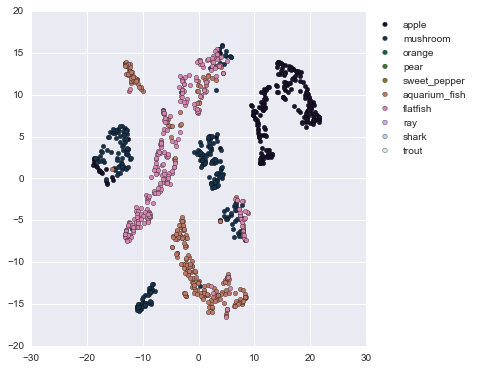

In [190]:
import vis

vis.visualize_embeddings_with_tsne("cnn_rnn_end_to_end_cifar100", X_test_fine_visualize, y_test_fine_visualize, fine_grain_classes)

In [89]:
print len(fine_or_coarse_test)
print np.sum(fine_or_coarse_test)

10000
10000


In [73]:
# Test on dataset
pred_test_probs = np.asarray(model.predict(X_test))

In [74]:
# Class predictions are in the form [A, B] (Coarse, Fine). 
def simplifyToHierarchicalFormat(class_predictions, end_token = 120):
    fine_labels_double_copy = np.reshape(np.tile(class_predictions, (2, 1)), (2, -1, 2))
    fine_labels_first = fine_labels_double_copy[0,:,1]
    fine_labels_second = fine_labels_double_copy[1,:,1]
    
    coarse_labels_mask = fine_labels_first
    coarse_labels_mask[coarse_labels_mask != end_token] = 0
    coarse_labels_mask[coarse_labels_mask == end_token] = 1
    
    hierarchical_labels =  fine_labels_second
    hierarchical_labels[hierarchical_labels == end_token] = 0
    
    return hierarchical_labels + class_predictions[:,0]*coarse_labels_mask


# Make predictions
test_predictions = pred_test_probs.reshape((-1, 2, 121))
test_predictions = np.argmax(test_predictions, axis=2)
test_predictions = simplifyToHierarchicalFormat(test_predictions)
test_predictions

array([116, 111, 112, ..., 100,  51, 108])

In [79]:
test_actual = np.copy(y_test)
test_actual[:,0] = y_test[:,1]
test_actual[:,1] = y_test[:,0]
test_actual[:,0] += 100
test_actual = simplifyToHierarchicalFormat(test_actual)
test_actual

array([33, 51, 15, ..., 50, 51, 42])

In [80]:
print np.equal(test_predictions, test_actual)
print len(np.equal(test_predictions, test_actual))
print np.sum(np.equal(test_predictions, test_actual)) 

[False False False ..., False  True False]
4000
1614


pine_tree


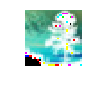

In [177]:
X_try = X_test.reshape(len(X_test), 3, 32, 32).transpose(0,2,3,1).astype("float")


plt.figure(num=None, figsize=(1, 1), dpi=32, facecolor='w', edgecolor='k')

# Print out examples
# Convert predictions to human-readable labels
fine_label_names, coarse_label_names = load_cifar100_label_names()

index = 15
image_to_show = X_test[index]
plt.axis('off')
plt.imshow(image_to_show, interpolation='nearest')
print fine_label_names[y_test[index][0]]

(32, 3, 32)


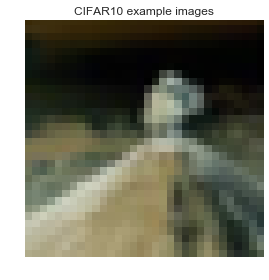

In [132]:
# Plot image examples.
def plot_img(img, title):
    plt.figure()
    plt.imshow(img, interpolation='nearest')
    plt.title(title)
    plt.axis('off')
    plt.tight_layout()


img_bhwc = np.transpose(X_test[0], (1, 2, 0))
#img_tile = dp.misc.img_tile(dp.misc.img_stretch(img_bhwc), aspect_ratio=0.75,
#                            border_color=1.0)
print img_bhwc.shape
plot_img(X_test[0], title='CIFAR10 example images')

NameError: name 'model_id' is not defined

['apple', 'mushroom', 'orange', 'pear', 'sweet_pepper']
['aquarium_fish', 'flatfish', 'ray', 'shark', 'trout']
